**FaceNet Model**

FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled “FaceNet: A Unified Embedding for Face Recognition and Clustering.”

It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.

FaceNet, that directly learns a mapping from face images to a compact Euclidean space where distances directly correspond to a measure of face similarity.

We will use the pre-trained Keras FaceNet model provided by Hiroki Taniai. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.

Model can be downloaded from the link: https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

I am using google colab for GPU access so these are some codes for importing the data and pretrained model from drive to the current working directory.

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**1. Upload the model in colab**

Upload the model file and place it in your current working directory with the filename ‘facenet_keras.h5‘.

In [2]:
link1 = 'https://drive.google.com/open?id=1zYrcC3ahctVtWlV6dndm-f7qavYkRQeb'
fluff, id_facenet = link1.split('=')
print (id_facenet) # Verify that you have everything after '='

1zYrcC3ahctVtWlV6dndm-f7qavYkRQeb


In [3]:
downloaded = drive.CreateFile({'id':id_facenet}) 
downloaded.GetContentFile('facenet.zip')

In [4]:
!unzip facenet.zip -d/content

Archive:  facenet.zip
replace /content/keras-facenet/weights/facenet_keras_weights.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: /content/keras-facenet/weights/facenet_keras_weights.h5  
replace /content/keras-facenet/model/facenet_keras.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


We can load the model directly in Keras using the load_model() function;

In [5]:
# example of loading the keras facenet model
from keras.models import load_model
# load the model
model = load_model('/content/keras-facenet/model/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)


[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


**2. Upload the dataset**

The 5 Celebrity Faces Dataset is a small dataset that contains photographs of celebrities. I have my friend Amit's images in that also so that it can detect 6 different classes.

It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling and amit.

The dataset was prepared and made available by Dan Becker and provided for free download on Kaggle. It can be downloaded from kaggle: https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

In [6]:
link2 = 'https://drive.google.com/open?id=1SVS5veE3dPwj0vIvISBAYoEZGdeFdnD-'
fluff, id_data = link2.split('=')
print (id_data) # Verify that you have everything after '='

1SVS5veE3dPwj0vIvISBAYoEZGdeFdnD-


In [7]:
downloaded = drive.CreateFile({'id':id_data}) 
downloaded.GetContentFile('data.zip')

In [8]:
!unzip data.zip -d/content

Archive:  data.zip
replace /content/5-celebrity-faces-dataset/train/amit/IMG-20160229-WA0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**3. Install MTCNN**

Face detection is the process of automatically locating faces in a photograph and localizing them by drawing a bounding box around their extent.

In this, we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled “Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.”

We will use the implementation provided by Iván de Paz Centeno in the ipazc/mtcnn project. This can also be installed via pip as follows:




In [9]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.4MB/s 


In [10]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


We can use the mtcnn library to create a face detector and extract faces for our use with the FaceNet face detector models in subsequent sections.

The first step is to load an image as a NumPy array, which we can achieve using the PIL library and the open() function. We will also convert the image to RGB, just in case the image has an alpha channel or is black and white.

In [11]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

If we assume there is only one face in the photo for our experiments, we can determine the pixel coordinates of the bounding box as follows. Sometimes the library will return a negative pixel index, and I think this is a bug. We can fix this by taking the absolute value of the coordinates.

We can use these coordinates to extract the face. We can then use the PIL library to resize this small image of the face to the required size; specifically, the model expects square input faces with the shape 160×160.

In [12]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

Let's plot some faces to have a look about our dataset.

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)
15 (160, 160, 3)
16 (160, 160, 3)


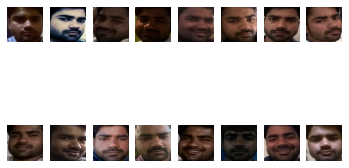

In [13]:
# specify folder to plot
folder = '/content/5-celebrity-faces-dataset/train/amit/'
i = 1
# enumerate files
for filename in listdir(folder):
  # path
  path = folder + filename
  # get face
  face = extract_face(path)
  print(i, face.shape)
  # plot
  pyplot.subplot(2, 8, i)
  pyplot.axis('off')
  pyplot.imshow(face)
  i += 1
pyplot.show()

**4. Prepare Data**

We can extend this to step over each subdirectory for a given dataset (e.g. ‘train‘ or ‘val‘), extract the faces, and prepare a dataset with the name as the output label for each detected face.

The load_faces() function below will load all of the faces into a list for a given directory.




In [14]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [18]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

We can then call this function for the ‘train’ and ‘val’ folders to load all of the data, then save the results in a single compressed NumPy array file via the savez_compressed() function.

In [19]:

# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 22 examples for class: mindy_kaling
>loaded 17 examples for class: elton_john
>loaded 16 examples for class: amit
>loaded 19 examples for class: madonna
>loaded 21 examples for class: jerry_seinfeld
(109, 160, 160, 3) (109,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: amit
>loaded 5 examples for class: madonna
>loaded 5 examples for class: jerry_seinfeld


In [20]:
print(testX.shape, testy.shape)

(30, 160, 160, 3) (30,)


**5. Create Face Embeddings**

The next step is to create a face embedding.

A face embedding is a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.

The classifier model that we want to develop will take a face embedding as input and predict the identity of the face. The FaceNet model will generate this embedding for a given image of a face.

The FaceNet model can be used as part of the classifier itself, or we can use the FaceNet model to pre-process a face to create a face embedding that can be stored and used as input to our classifier model. This latter approach is preferred as the FaceNet model is both large and slow to create a face embedding.

We can, therefore, pre-compute the face embeddings for all faces in the train and test (formally ‘val‘) sets in our 5 Celebrity Faces Dataset.



In [21]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

In [22]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]


In [23]:
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)


Loaded:  (109, 160, 160, 3) (109,) (30, 160, 160, 3) (30,)


In [24]:
# load the facenet model
model = load_model('/content/keras-facenet/model/facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [25]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(109, 128)


In [26]:
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(30, 128)


In [27]:
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

**6.Perform Face Classification**

In this section, we will develop a model to classify face embeddings as one of the known celebrities in the 5 Celebrity Faces Dataset.italicized text



In [28]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

the data requires some minor preparation prior to modeling.

First, it is a good practice to normalize the face embedding vectors. It is a good practice because the vectors are often compared to each other using a distance metric.

In this context, vector normalization means scaling the values until the length or magnitude of the vectors is 1 or unit length. This can be achieved using the Normalizer class in scikit-learn. It might even be more convenient to perform this step when the face embeddings are created in the previous step.



In [29]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

Dataset: train=109, test=30


the string target variables for each celebrity name need to be converted to integers.

This can be achieved via the LabelEncoder class in scikit-learn

In [30]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

It is common to use a Linear Support Vector Machine (SVM) when working with normalized face embedding inputs. This is because the method is very effective at separating the face embedding vectors. We can fit a linear SVM to the training data using the SVC class in scikit-learn and setting the ‘kernel‘ attribute to ‘linear‘. We may also want probabilities later when making predictions, which can be configured by setting ‘probability‘ to ‘True‘.

This can be achieved by using the fit model to make a prediction for each example in the train and test datasets and then calculating the classification accuracy.



In [31]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


the model is evaluated on the train and test dataset, showing perfect classification accuracy. This is not surprising given the size of the dataset and the power of the face detection and face recognition models used.

In [32]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


We can make it more interesting by plotting the original face and the prediction.

First, we need to load the face dataset, specifically the faces in the test dataset. We could also load the original photos to make it even more interesting.



In [33]:
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

Next, we can use the face embedding as an input to make a single prediction with the fit model.

We can predict both the class integer and the probability of the prediction.

In [35]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

We can then get the name for the predicted class integer, and the probability for this prediction.

In [38]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: mindy_kaling (81.301)
Expected: mindy_kaling


We can also plot the face pixels along with the predicted name and probability.

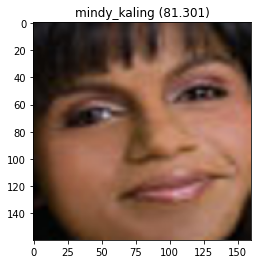

In [37]:
# plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()